In [6]:
import pandas as pd
from textdistance import hamming
from scipy.special import binom
from tqdm import tqdm
from itertools import combinations
from pathlib import Path
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np


def rec_dd():
    return defaultdict(rec_dd)


In [7]:
benchmark_path = Path(
    "/home/gabrielathenes/Documents/study/HILARy/data_with_scripts/benchmark_on_partis_dataset/"
)
hilary = "hilary-full-1-2-0"


In [8]:
def pairwise_evaluation(df, partition, ground_truth="simulations"):
    TP = 0
    P = binom(df.groupby([ground_truth]).size(), 2).sum()
    TP_FP = binom(df.groupby([partition]).size(), 2).sum()
    for _, family in tqdm(df.groupby([ground_truth]), disable=True):
        for r1, r2 in combinations(family[partition], 2):
            if r1 == r2:
                TP += 1
    if TP_FP == 0:
        return 0.0, 1.0
    elif P == 0:
        return None, None
    return (
        TP / P,
        TP / TP_FP,
    )  # sensitivity, precision

def entropy(dfGrouped):
    fs = dfGrouped.size()
    fs = fs / sum(fs)
    return sum(fs * np.log2(fs))


def variation_of_info(df, result):
    VI = (
        entropy(df.groupby(["simulations"]))
        + entropy(df.groupby([result]))
        - 2 * entropy(df.groupby([result, "simulations"]))
    )
    return VI


In [9]:
metric_dict=rec_dd()
for seed in [0, 1, 2]:
    prec_list=[]
    sens_list=[]
    var_list=[]
    dataframe=pd.DataFrame()
    for model in ["simulations","partis","scoper",hilary]:
        print(seed,model)
        if model=="scoper":
            df = pd.read_csv(benchmark_path
                        / Path(
                            f"seed-{seed}/scratch-mute-freq-0.10/{model}/both_chains/partition.tsv"
                        ),
                sep="\t",
                index_col="sequence_id",
            )
        else :
            df = pd.read_csv(
                [
                    each
                    for each in (benchmark_path
                    / Path(
                        f"seed-{seed}/scratch-mute-freq-0.10/{model}/both_chains/"
                    )).glob(f"*igh.tsv")
                ][0],
                sep="\t",
                index_col="sequence_id",
        )
        if model.startswith("hilary"):
            dataframe[model]=df["family"]
            dataframe["cdr3_length"]=df["cdr3_length"]
            dataframe[model + "_cdr3-based"] = df["cdr3_based_family"]
        else :
            dataframe[model]=df["clone_id"]

    grouped=dataframe.groupby("cdr3_length")
    for l,df_grouped in grouped :
        if l>45:continue
        for model in ["partis","scoper",hilary,f"{hilary}_cdr3-based"]:
            sensitivity,precision=pairwise_evaluation(df_grouped,model)
            varinfo = variation_of_info(df_grouped,model)
            metric_dict[model]["precision"][l][seed]=precision
            metric_dict[model]["sensitivity"][l][seed]=sensitivity
            metric_dict[model]["variation_of_info"][l][seed]=varinfo


0 simulations
0 partis
0 scoper
0 hilary-full-1-2-0
1 simulations
1 partis
1 scoper
1 hilary-full-1-2-0
2 simulations
2 partis
2 scoper
2 hilary-full-1-2-0


precision
sensitivity
variation_of_info
precision
sensitivity
variation_of_info
HILARy-full
precision
sensitivity
variation_of_info
precision
sensitivity
variation_of_info


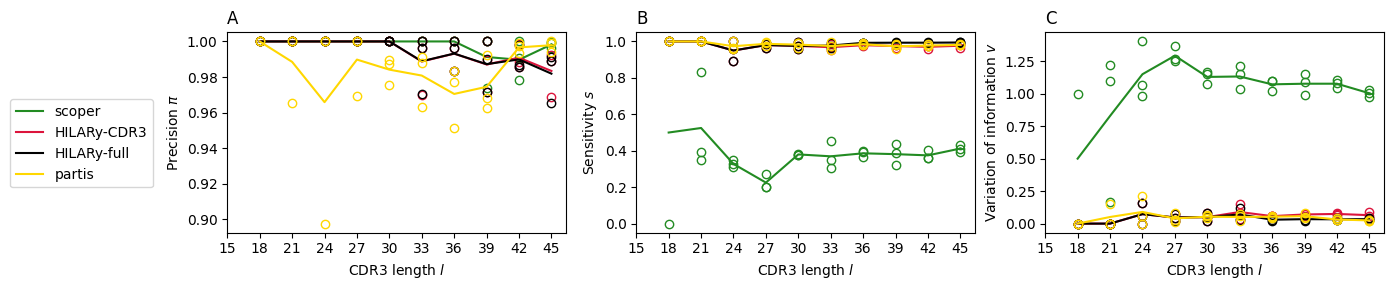

In [13]:
ls = np.arange(15, 45 + 3, 3)
fig = plt.figure(figsize=(14, 3))
ax1 = fig.add_subplot(131)
ax1.set_ylabel(r"Precision $\pi$")
ax1.set_xlabel("CDR3 length $l$")
ax2 = fig.add_subplot(132)
ax2.set_ylabel("Sensitivity $s$")
ax2.set_xlabel("CDR3 length $l$")
ax3 = fig.add_subplot(133)
ax3.set_ylabel(r"Variation of information $v$")
ax3.set_xlabel("CDR3 length $l$")

colors = {
    "scoper": "forestgreen",
    f"{hilary}_cdr3-based": "crimson",
    hilary: "k",
    "partis": "gold",
}
axes = [ax1, ax2, ax3]

for model in colors:
    if model == hilary:
        label = "HILARy-full"
        print(label)
    elif model == f"{hilary}_cdr3-based":
        label = "HILARy-CDR3"
    else:
        label = model
    for i, metric in enumerate(metric_dict[model]):
        print(metric)
        for l in metric_dict[model][metric]:
            y = list(metric_dict[model][metric][l].values())
            x = [l] * len(y)
            axes[i].plot(
                x,
                y,
                "o",
                fillstyle="none",
                color=colors[model],
            )
        lengths = []
        averages = []
        for length in metric_dict[model][metric]:
            lengths.append(length)
            averages.append(np.mean(list(metric_dict[model][metric][length].values())))
        axes[i].plot(
            lengths,
            averages,
            color=colors[model],
            label=label,
        )
        axes[i].set_title(["A","B","C"][i],loc="left")


ax1.set_xticks(ls)
ax1.set_xticklabels(ls)
ax2.set_xticks(ls)
ax2.set_xticklabels(ls)
ax3.set_xticks(ls)
ax3.set_xticklabels(ls)

ax1.legend(bbox_to_anchor=(-2.5, -0.1, 2.3, 0.8))

plt.tight_layout()
plt.savefig(
    "/home/gabrielathenes/Dropbox/Natanael_lineages_inference/revisions_2024_01_26/figures/figure5_cdr3l.png",
)
plt.show()
